# Setup

## Imports

In [ ]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import webbrowser
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set, Union
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False);

from arena3.chapter1_transformer_interp.exercises.plotly_utils import imshow, line, scatter, bar
import tests

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

## Loading our model

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

#### Note on `refactor_factored_attn_matrices`


In [ ]:
# Show column norms are the same (except first few, for fiddly bias reasons)
line([model.W_Q[0, 0].pow(2).sum(0), model.W_K[0, 0].pow(2).sum(0)])
# Show columns are orthogonal (except first few, again)
W_Q_dot_products = einops.einsum(
    model.W_Q[0, 0], model.W_Q[0, 0], "d_model d_head_1, d_model d_head_2 -> d_head_1 d_head_2"
)
imshow(W_Q_dot_products)

### Verify model *can* do task!

**Aside**: if we were being careful, we'd want to run the model on a range of prompts and find the average performance. We'll do more stuff like this in the fourth section (when we try to replicate some of the paper's results, and take a more rigorous approach).

In [ ]:
# Here is where we test on a single prompt
# Result: 70% probability on Mary, as we expect

example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = " Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

It can. Correct token " Mary" has 70% probability. Muletiple prompts: 

In [ ]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" John", " Mary"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]

# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [
    prompt.format(name) 
    for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1] 
]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = t.concat([
    model.to_tokens(names, prepend_bos=False).T for names in answers
])

rprint(prompts)
rprint(answers)
rprint(answer_tokens)

table = Table("Prompt", "Correct", "Incorrect", title="Prompts & Answers:")

for prompt, answer in zip(prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))

rprint(table)

In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# Move the tokens to the GPU
tokens = tokens.to(device)
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

### Exercise: implement the performance evaluation function

In [ ]:
def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False
) -> Union[Float[Tensor, ""], Float[Tensor, "*batch"]]:
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''
    diffs = -logits[:, -1, :].gather(dim=-1, index=answer_tokens).diff(dim=-1).squeeze()
    if per_prompt:
        return diffs
    else:
        return diffs.mean()


tests.test_logits_to_ave_logit_diff(logits_to_ave_logit_diff)

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt", 
    Column("Correct", style="rgb(0,200,0) bold"), 
    Column("Incorrect", style="rgb(255,0,0) bold"), 
    Column("Logit Difference", style="bold")
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

Actual probability difference $=e^{logitDiff}$. So, for our first example, the model predicts the correct token with $e^{3.202} = 24.6 \times$ higher probability than the incorrect token

# Logit Attribution
- Perform direct logit attribution to figure out which heads are writing to the residual stream in a significant way

- Learn how to use different transformerlens helper functions, which decompose the residual stream in different ways

## Direct Logit Attribution
- The easiest part of the model to understand is the output - this is what the model is trained to optimize, and so it can always be directly interpreted
- Often the right approach to reverse engineering a circuit is to start at the end, understand how the model produces the right answer, and to then work backwards
- The main technique used to do this is called **direct logit attribution**

- Decompose the logits into the sum of the contributions of each component, and look at which components contribute the most to the logit of the correct token
- Here we look at the direct attribution to the logit difference

### Background and motivation of the logit difference
- Note that model is trained to optimise **cross-entropy loss***; i.e., **log probabilities**, not logits!

- Want to use logits: easier to understand. Also, logit difference controls for some of the many other components of the task; e.g., deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc.

- But is it safe? E.g., adding a constant to all logits leaves log probabilities unchanged

- This is okay, because we are looking at logit *difference*, and the arbitrary constant would cancel out (easy enough to prove). I.e.:
  - `log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")`

### Logit diff directions

- **Getting an output logit is equivalent to projecting onto (dot-producting with) a direction in the residual stream, and the same is true for getting the logit diff.**

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens) # [batch 2 d_model]
print("Answer residual directions shape:", answer_residual_directions.shape)

correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions = correct_residual_directions - incorrect_residual_directions # [batch d_model]
print(f"Logit difference directions shape:", logit_diff_directions.shape)

In [ ]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type]. 

final_residual_stream = cache["resid_post", -1] # [batch seq d_model]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream = final_residual_stream[:, -1, :] # [batch d_model]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer=-1, pos_slice=-1)

average_logit_diff = einops.einsum(
    scaled_final_token_residual_stream, logit_diff_directions,
    "batch d_model, batch d_model ->"
) / len(prompts)

print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

t.testing.assert_close(average_logit_diff, original_average_logit_diff)

## Logit Lens

### Exercise: implement `residual_stack_to_logit_diff()`

In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"], 
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given 
    stack of components in the residual stream.
    '''
    return einops.einsum(
        cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1), logit_diff_directions,
        "... batch d_model, batch d_model -> ..."
    ) / residual_stack.size(-2)


t.testing.assert_close(
    residual_stack_to_logit_diff(final_token_residual_stream, cache),
    original_average_logit_diff
)

#### Plot results:
- Key for the plot below: `n_pre` means the residual stream at the start of layer `n`, `n_mid` means the residual stream after the attention part of layer `n` (`n_post` is the same as `n+1_pre` so is not included)

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache) # [component]

line(
    logit_lens_logit_diffs, 
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800
)

##### Interpretation

1. Model utterly unable to do task until **layer 7**

2. Almost all of the work is being done between `9_pre` and `9_med`. I.e., **the attention layer in layer 9**

2. Perform *decreases* in subsequent layers!

## Layer Attribution

- Repeat above, but for each layer.

- Equivalent to differences between adjacent residual streams

In [ ]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)

line(
    per_layer_logit_diffs, 
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800
)

#### Interpretation:
- Only attention layers matter (in both directions!)

## Head Attribution

- Can break down further from layer to outputs of each attention head

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual, 
    "(layer head) ... -> layer head ...", 
    layer=model.cfg.n_layers
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)

imshow(
    per_head_logit_diffs, 
    labels={"x":"Head", "y":"Layer"}, 
    title="Logit Difference From Each Head",
    width=600
)

#### Interpretation
- Only a few heads really matter:
  - `9.6` and `9.9` contribute a lot positively
  - `10.7` contributes a lot negatively. Also somewhat `11.10`

- There are also several heads that matter positively or negatively but less strongly (other name movers and backup name movers)

#### Other meta points:
- Our model has 144 heads, yet we could localise this behaviour to a handful of specific heads, using straightforward, general techniques! This supports the claim in *A Mathematical Framework* that attention heads are the right level of abstraction to understand attention.

- Really surprising that there are *negative heads*! Head `10.7` makes the incorrect logit **7x more likely**.

## Useful Functions Recap

- `cache.apply_ln_to_stack()`
  - Apply layernorm scaling to a stack of residual stream values.
  - We used this to help us go from "final value in residual stream" to "projection of logits in logit difference directions", without getting the code too messy!
- `cache.accumulated_resid(layer=None)`
  - Returns the accumulated residual stream up to layer `layer` (or up to the final value of residual stream if `layer` is None), i.e. a stack of previous residual streams up to that layer's input.
  - Useful when studying the **logit lens**.
  - First dimension of output is `(0_pre, 0_mid, 1_pre, 1_mid, ..., final_post)`
- `cache.decompose_resid(layer)`.
  - Decomposes the residual stream input to layer `layer` into a stack of the output of previous layers. The sum of these is the input to layer `layer`.
  - First dimension of output is `(embed, pos_embed, 0_attn_out, 0_mlp_out, ...)`.
- `cache.stack_head_results(layer)`
  - Returns a stack of all head results (i.e. residual stream contribution) up to layer `layer`
  - (i.e. like `decompose_resid` except it splits each attention layer by head rather than splitting each layer by attention/MLP)
  - First dimension of output is `layer * head` (we needed to rearrange to `(layer, head)` to plot it).

## Attention Analysis

- Attention heads are useful to study because we can look directly at their attention patterns and study from which and to which positions they move information.

- We're looking at the direct effect on the logits, so we need only look at the attention patterns from the final token

### Interpreting attention patterns:
- A common mistake to make when looking at attention patterns is thinking that they must convey information about the *token* looked at (maybe accounting for the context of the token).

- But actually, all we can confidently say is that it moves information from the *residual stream position* corresponding to that input token.

- Especially later on in the model, there may be components in the residual stream that are nothing to do with the input token!
  - E.g. the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"

In [ ]:
def topk_of_Nd_tensor(tensor: Float[Tensor, "rows cols"], k: int):
    '''
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    '''
    i = t.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(per_head_logit_diffs * (1 if head_type=="Positive" else -1), k)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack([
        cache["pattern", layer][:, head][0]
        for layer, head in top_heads
    ])

    # Display results
    display(HTML(f"<h2>Top {k} {head_type} Logit Attribution Heads</h2>"))
    display(cv.attention.attention_patterns(
        attention = attn_patterns_for_important_heads,
        tokens = model.to_str_tokens(tokens[0]),
        attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
    ))

# Activation Patching

- Understand the idea of activation patching, and how it can be used
  - Implement some of the activation patching helper functions in transformerlens from scratch (i.e. using hooks)
  
- Use activation patching to track the layers & sequence positions in the residual stream where important information is stored and processed

- By the end of this section, you should be able to draw a rough sketch of the IOI circuit

## Introduction
- Obvious limitation of above techniques: *they only look at the very end of the circuit*; the parts that directly affect the logits.

- Not sufficient to understand the circuit; we want to understand how things **compose** together to produce the final output.
  - Ideally, produce an end-to-end circuit that fully explains the behaviour

- To do this, use **activation patching** (also called *causal tracing*)

### Setup:
1. Take two runs of the model on two different inputs: the *clean* run and the *corrupted* run.
   - Clean run outputs correct answer, corrupted one does not.

2. Give model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run, and then continue.

3. Measure how much the output in the patched, corrupted run has updated towards the correct answer.

4. Iterate over many possible activations and identify which patch significantly increases the probability of the correct answer.
   - In this way, we *localise* which activations matter

### Notes:

- This is a **noising** algorithm. Last section was mostly **denoising**.

- The ability to localise is a key move in mechanistic interpretability.
  - If the computation is diffuse and spread across the entire model, it is probably hard to form a clean mechanistic story for what's going on.
  
  - If we can identify precisely which parts of the model matter, we can then zoom in and determine what they represent and how they connect up with each other, and ultimately reverse engineer the underlying circuit that they represent.


## Concrete example

- *Clean input:* the original sentences. E.g., `"When Mary and John went to the store, John gave a drink to"`

- *Corrupt input:* the original sentences with the subject token flipped. E.g., `"When Mary and John went to the store, Mary gave a drink to"`

- Patching from the corrupted input to the clean input is a causal intervention which will allow us to understand precisely which parts of the network are identifying the indirect object.
  - If a component is important, patching into that component will reverse the signal that this component produces, hence making performance much worse.

- One natural thing to patch is the residual stream at a specific layer & position.
  - The model is likely intitially doing some processing on the `S2` token to realise that it's a duplicate, but then uses attention to move that information to the `end` token

- We can zoom in much further and patch in specific activations from specific layers.
  - E.g., we think that the output of head 9.9 on the final token is significant for directly connecting to the logits, so we predict that just patching the output of this head will significantly affect performance.

- Note that this technique does *not* tell us how the components of the circuit connect up, just what they are.

### Question: why not use corrupted sentences that flip *all three* names in the original sentences? E.g., `"When John and Mary went to the store, Mary gave a drink to"`

- The mode count point to the indirect object via either **token information** or **position information**. E.g.:
  - Token information: *"the indirect object is the token `' Mary'`".*
  
  - Positional information: *"the indirect object is the fourth token in this sequence*

- **We want the corrupted dataset to reverse both these signals**
  - If we corrupted the dataset by flipped all three names, the token information will be flipped, but the positional information will *not* be flipped.

## Task: implement some activation patching functions and compare to built-in `TransformerLens` counterparts

In [ ]:
from transformer_lens import patching

### Exercise: Create a metric
- Before we patch, we need to create a metric for evaluating a set of logits.

- Since we'll be running our corrupted prompts (with S2 replaced with the wrong name) and patching in our clean prompts, it makes sense to choose a metric such that:
  - A value of zero means no change (from the performance on the corrupted prompt)
  - A value of one means clean performance has been completely recovered

- E.g., if we patched in the entire clean prompt, we'd get a value of one.
  - If our patching actually makes the model even better at solving the task than its regular behaviour on the clean prompt then we'd get a value greater than 1, but generally we expect values between 0 and 1.

- It also makes sense to have the metric be a linear function of the logit difference. This is enough to uniquely specify a metric.

#### **Important note**
We've defined the metric to be 0 when performance is the same as on corrupted input, and 1 when it's the same as on clean input. Why have we done it this way around?

- In this section, we'll be applying **denoising** rather than **noising** methods. Denoising means we start with the corrupted input (i.e. no signal, or negative signal) and patch in with the clean input (i.e. positive signal).
  - This is an important conceptual distinction. When we perform denoising, we're looking for parts of the model which are **sufficient** for the task
    - E.g., which parts of the model have enough information to recover the correct answer from the corrupted input.
    
  - Our **null hypothesis** is that a part of the model isn't important, and so changing its value won't get us from corrupted to clean values.

- On the other hand, noising means taking a clean run and patching in with corrupted values
  - Tests whether a component is **necessary**.

  - Our **null hypothesis** that the component isn't important now has a different implication: *replacing its values with those on the corrupted input won't prevent the model from being able to perform the task*.
  
  - In later sections, we'll be doing noising, and we'll define a new metric function for this.

In [ ]:
clean_tokens = tokens
# Swap each adjacent pair to get corrupted tokens
indices = [i+1 if i % 2 == 0 else i-1 for i in range(len(tokens))]
corrupted_tokens = clean_tokens[indices]

print(
    "Clean string 0:    ", model.to_string(clean_tokens[0]), "\n"
    "Corrupted string 0:", model.to_string(corrupted_tokens[0])
)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

In [ ]:
def ioi_metric(
    logits: Float[Tensor, "batch seq d_vocab"], 
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[Tensor, ""]:
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is 
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    diff = logits_to_ave_logit_diff(logits, answer_tokens)

    return (diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


t.testing.assert_close(ioi_metric(clean_logits).item(), 1.0)
t.testing.assert_close(ioi_metric(corrupted_logits).item(), 0.0)
t.testing.assert_close(ioi_metric((clean_logits + corrupted_logits) / 2).item(), 0.5)

## Residual Stream Patching
- Begin with a simple example: patch in the residual stream at the start of each layer and for each token position.

- Let's first see what this looks like with `TransformerLens`' patching module in the code below:

In [ ]:
act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model = model,
    corrupted_tokens = corrupted_tokens,
    clean_cache = clean_cache,
    patching_metric = ioi_metric
)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

imshow(
    act_patch_resid_pre, 
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600
)

#### Interpretation

***Note**: for reference, tokens and their index from the first prompt are on the x-axis. In an abuse of notation, note that the difference here is **averaged over all 8 prompts**, while the labels only come from the first prompt.*

- Originally all relevant computation happens on `S2` ("Mary", in the case of the first prompt), and at layers 7 and 8, the information is moved to `END`.

- Moving the residual stream at the correct position near *exactly* recovers performance!

- To be clear, the striking thing about this graph is not that the first row is zero everywhere except for S2 where it is 1, nor that the rows near the end trend to being zero everywhere except for END where they are 1; both of these are exactly what we'd expect. The striking things are:
  1. The computation is highly localized; the relevant information for choosing `IO` over `S` is initially stored in S2 token and then moved to END token without taking any detours.
  
  2. The model is basically done after layer 8, and the rest of the layers actually slightly impede performance on this particular task.

### Exercise: implement head-to-residual patching

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[Tensor, "batch pos d_model"],
    hook: HookPoint, 
    pos: int, 
    clean_cache: ActivationCache
) -> Float[Tensor, "batch pos d_model"]:
    '''
    Patches a given sequence position in the residual stream, using the value
    from the clean cache.
    '''
    corrupted_residual_component[:, pos] = clean_cache[hook.name][:, pos]
    return corrupted_residual_component

def get_act_patch_resid_pre(
    model: HookedTransformer, 
    corrupted_tokens: Float[Tensor, "batch pos"], 
    clean_cache: ActivationCache, 
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float]
) -> Float[Tensor, "layer pos"]:
    '''
    Returns an array of results of patching each position at each layer in the residual
    stream, using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    '''
    model.reset_hooks()
    seq_len = corrupted_tokens.size(1)
    results = t.zeros(model.cfg.n_layers, seq_len, device=device, dtype=t.float32)

    for layer in tqdm(range(model.cfg.n_layers)):
        for position in range(seq_len):
            hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens, 
                fwd_hooks = [(utils.get_act_name("resid_pre", layer), hook_fn)], 
            )
            results[layer, position] = patching_metric(patched_logits)

    return results

act_patch_resid_pre_own = get_act_patch_resid_pre(model, corrupted_tokens, clean_cache, ioi_metric)

t.testing.assert_close(act_patch_resid_pre, act_patch_resid_pre_own)

In [ ]:
imshow(
    act_patch_resid_pre_own, 
    x=labels, 
    title="Logit Difference From Patched Residual Stream", 
    labels={"x":"Sequence Position", "y":"Layer"},
    width=600 # If you remove this argument, the plot will usually fill the available space
)

The above matches the builtin `TransformerLes` function perfectly.

## Patching in residual stream by block
- Rather than just patching to the residual stream in each layer, we can also patch just after either the attention layer of the MLP layer.
  - Gives a slightly more refined view of which tokens matter and when.

-  The function `patching.get_act_patch_block_every()` works just like `get_act_patch_resid_pre()`, but rather than just patching to the residual stream, it patches to `resid_pre`, `attn_out` and `mlp_out`, and returns a tensor of shape `(3, n_layers, seq_len)`

- **Note**: we're cycling through the `resid_pre`, `attn_out` and `mlp_out` and only patching one of them at a time, rather than patching all three at once.

In [ ]:
act_patch_block_every = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)

imshow(
    act_patch_block_every,
    x=labels, 
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"], # Subtitles of separate plots
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1000,
)

#### Interpretation of the Attention and MLP plots:
- Several attention layers are significant, but as with the residual stream, early layers matter on `S2` and later layers matter on `END`.
  - Layers essentially don't matter on any other token
  - Very localised!

- In contrast, the MLP layers do not matter much.
  - This makes sense, since this is more a task about *moving information* than about *processing* it (MLP layers specialise in processing information).

  - Only exception is MLP 0, which matters a lot. **Probably misleading** and just a generally true statement about MLP 0 rather than being about the circuit on this task:
    - Often observed on GPT-2 Small that MLP0 matters a lot, and that ablating it utterly destroys performance.

    - My current best guess is that the first MLP layer is essentially acting as an extension of the embedding (for whatever reason) and that when later layers want to access the input tokens they mostly read in the output of the first MLP layer, rather than the token embeddings.
      - Within this frame, the first attention layer doesn't do much.
    
    - In this framing, it makes sense that MLP0 matters on `S2`, because that's the one position with a different input token!

    - Maybe because the embedding and unembedding matrices in GPT-2 Small are the same? This is pretty unprincipled, as the tasks of embedding and unembedding tokens are not inverses, but this is common practice.
      - Plausibly, models want to dedicate some parameters to overcoming this.

    - Only suggestive evidence of this, and would love to see someone look into this properly!

### Exercise (optional): implement head-to-block patching

In [ ]:
def get_act_patch_block_every(
    model: HookedTransformer, 
    corrupted_tokens: Float[Tensor, "batch pos"], 
    clean_cache: ActivationCache, 
    patching_metric: Callable[[Float[Tensor, "batch pos d_vocab"]], float]
) -> Float[Tensor, "3 layer pos"]:
    '''
    Returns an array of results of patching each position at each layer in the residual
    stream, using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    '''
    COMPONENTS = ("resid_pre", "attn_out", "mlp_out")
    model.reset_hooks()
    results = t.zeros(len(COMPONENTS), model.cfg.n_layers, tokens.size(1), device=device, dtype=t.float32)

    for component_idx, component in enumerate(COMPONENTS):
        for layer in tqdm(range(model.cfg.n_layers)):
            for position in range(corrupted_tokens.shape[1]):
                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                patched_logits = model.run_with_hooks(
                    corrupted_tokens, 
                    fwd_hooks = [(utils.get_act_name(component, layer), hook_fn)], 
                )
                results[component_idx, layer, position] = patching_metric(patched_logits)

    return results  

act_patch_block_every_own = get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)

t.testing.assert_close(act_patch_block_every, act_patch_block_every_own)

imshow(
    act_patch_block_every_own,
    x=labels, 
    facet_col=0,
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"],
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1000
)

## Head Patching

- We can refine the above analysis by patching in individual heads!

- This is somewhat more annoying, because there are now three dimensions (`head_index`, `position` and `layer`)

- The code below patches a head's output over all sequence positions, and returns the results (for each head in the model)

In [ ]:
act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(
    model, 
    corrupted_tokens, 
    clean_cache, 
    ioi_metric
)

imshow(
    act_patch_attn_head_out_all_pos, 
    labels={"y": "Layer", "x": "Head"}, 
    title="attn_head_out Activation Patching (All Pos)",
    width=600
)

#### Interpretation
- We see some of the heads that we observed in our attention plots at the end of last section.
  - E.g. `9.9` having a large positive score, and `10.7` having a large negative score.
  
- But we can also see some other important heads, for instance:
  - In layers 7-8 there are several important heads. We might deduce that these are the ones responsible for moving information from `S2` to `end`.

  - In the earlier layers, there are some more important heads (e.g,. `3.0` and `5.5`). We might guess these are performing some primitive logic. E.g., causing the second `" John"` token to attend to previous instances of itself.

### Exercise: implement head-to-head patching

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint, 
    head_index: int, 
    clean_cache: ActivationCache
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    Patches the output of a given head (before it's added to the residual stream) at
    every sequence position, using the value from the clean cache.
    '''
    corrupted_head_vector[:, :, head_index] = clean_cache[hook.name][:, :, head_index]
    return corrupted_head_vector

def get_act_patch_attn_head_out_all_pos(
    model: HookedTransformer, 
    corrupted_tokens: Float[Tensor, "batch pos"], 
    clean_cache: ActivationCache, 
    patching_metric: Callable
) -> Float[Tensor, "layer head"]:
    '''
    Returns an array of results of patching at all positions for each head in each
    layer, using the value from the clean cache.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    '''
    model.reset_hooks()
    results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=t.float32)

    for layer in tqdm(range(model.cfg.n_layers)):
        for head in range(model.cfg.n_heads):
            hook_fn = partial(patch_head_vector, head_index=head, clean_cache=clean_cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens, 
                fwd_hooks = [(utils.get_act_name("z", layer), hook_fn)], 
                return_type="logits" 
            )
            results[layer, head] = patching_metric(patched_logits)

    return results  


act_patch_attn_head_out_all_pos_own = get_act_patch_attn_head_out_all_pos(model, corrupted_tokens, clean_cache, ioi_metric)

t.testing.assert_close(act_patch_attn_head_out_all_pos, act_patch_attn_head_out_all_pos_own)

imshow(
    act_patch_attn_head_out_all_pos_own,
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x":"Head", "y":"Layer"},
    width=600
)

## Decomposing Heads
- Decomposing attention layers into patching in individual heads has already helped us localise the behaviour a lot, but we can understand it further by **decomposing heads**.

- An attention head consists of two semi-independent operations:
  1. calculating *where to move information from and to*, represented by the attention pattern and implemented via the QK-circuit; and
  
  2. calculating *what information to move*,represented by the value vectors and implemented by the OV-circuit

- We can disentangle which of these is important by patching in just the attention pattern or the value vectors

- A useful function for doing this is `get_act_patch_attn_head_all_pos_every()`. Rather than just patching on head output (like the previous one), it patches on:

  - Output (this is equivalent to patching the value the head writes to the residual stream)

  - Querys (i.e., the patching the query vectors, without changing the key or value vectors)

  - Keys

  - Values

  - Patterns (i.e., the attention patterns).

- **Again, note**: this function is *not* patching multiple things at once. It's looping through each of these five, and getting the results from patching them one at a time.

In [ ]:
act_patch_attn_head_all_pos_every = patching.get_act_patch_attn_head_all_pos_every(
    model, 
    corrupted_tokens, 
    clean_cache, 
    ioi_metric
)

imshow(
    act_patch_attn_head_all_pos_every, 
    facet_col=0, 
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)", 
    labels={"x": "Head", "y": "Layer"},
)

#### Interpretation
Striking features:
- At least 3 different groups of heads:

  1. Earlier heads (`3.0`, `5.5`, `6.9`) that matter because of their attention patterns (specifically, their query vectors)
  
  2. Middle heads in layers 7 & 8 (`7.3`, `7.9`, `8.6`, `8.10`) seem to matter more because of their value vectors.
     - *View attention pattern plots below.* These show that the heads attend from `END` to `S2`, so they're *responsible for moving information from `S2` to `END`*.

     - Agrees with our earlier results, when we saw that most of the info gets moved over layers 7 and 8.

     - The fact that *value patching* is the most important thing for them suggests that the interesting computation goes into what information they move from `S2` to `end`, rather than why `end` attends to `S2`
       - When we value patch, the info about the identity of `S2` that gets moved from `S2` to `END` would *flip* between "Mary" and "John".
         - It would push the result in the opposite direction
       - In contrast, if *key patching* were important, `END` would attend to `S2` regardless of the identity of the `S2` token.

  3. Later heads which improve the logit difference (`9.9`, `10.0`), which matter because of their query vectors.

In [ ]:
# Get the heads with largest value patching
# (we know from plot above that these are the 4 heads in layers 7 & 8)
k = 4
top_heads = topk_of_Nd_tensor(act_patch_attn_head_all_pos_every[3], k=k)

# Get all their attention patterns
attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack([
    cache["pattern", layer][:, head].mean(0)
        for layer, head in top_heads
])

# Display results
display(HTML(f"<h2>Top {k} Logit Attribution Heads (from value-patching)</h2>"))
display(cv.attention.attention_patterns(
    attention = attn_patterns_for_important_heads,
    tokens = model.to_str_tokens(tokens[0]),
    attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
))

### Exercise (optional): implement head-to-head-input patching

In [ ]:
def patch_attn_patterns(
    corrupted_head_vector: Float[Tensor, "batch head_index pos_q pos_k"],
    hook: HookPoint, 
    head_index: int, 
    clean_cache: ActivationCache
) -> Float[Tensor, "batch head_index d_head"]:
    '''
    Patches the attn patterns of a given head at every sequence position, using 
    the value from the clean cache.
    '''
    corrupted_head_vector[:, head_index] = clean_cache[hook.name][:, head_index]
    return corrupted_head_vector

def get_act_patch_attn_head_all_pos_every(
    model: HookedTransformer,
    corrupted_tokens: Float[Tensor, "batch pos"],
    clean_cache: ActivationCache,
    patching_metric: Callable
) -> Float[Tensor, "layer head"]:
    '''
    Returns an array of results of patching at all positions for each head in each
    layer (using the value from the clean cache) for output, queries, keys, values
    and attn pattern in turn.

    The results are calculated using the patching_metric function, which should be
    called on the model's logit output.
    '''
    COMPONENTS = ("z", "q", "k", "v", "pattern")
    model.reset_hooks()
    results = t.zeros(len(COMPONENTS), model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=t.float32)

    for component_idx, component in enumerate(COMPONENTS):
        for layer in tqdm(range(model.cfg.n_layers)):
            for head in range(model.cfg.n_heads):
                    hook_fn_general = patch_attn_patterns if component == "pattern" else patch_head_vector
                    hook_fn = partial(hook_fn_general, head_index=head, clean_cache=clean_cache)
                    patched_logits = model.run_with_hooks(
                        corrupted_tokens, 
                        fwd_hooks = [(utils.get_act_name(component, layer), hook_fn)], 
                        return_type="logits" 
                    )
                    results[component_idx, layer, head] = patching_metric(patched_logits)
    
    return results


act_patch_attn_head_all_pos_every_own = get_act_patch_attn_head_all_pos_every(
    model,
    corrupted_tokens,
    clean_cache,
    ioi_metric
)

t.testing.assert_close(act_patch_attn_head_all_pos_every, act_patch_attn_head_all_pos_every_own)

imshow(
    act_patch_attn_head_all_pos_every_own,
    facet_col=0,
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)",
    labels={"x": "Head", "y": "Layer"},
    width=1200
)

**Note**: We can do this in an even more fine-grained way; the function `patching.get_act_patch_attn_head_`**`by`**`_pos_every()` (i.e., same as above but replacing `all_pos` with `by_pos`) will give you the same decomposition, but by sequence position as well as by layer, head and component.
- The same holds for `patching.get_act_patch_attn_head_out_all_pos()` earlier (replace `all_pos` with `by_pos`). These functions are unsurprisingly pretty slow though!

## Consolidating Understanding

Recap of most important observations:

1. Heads `9.9`, `9.6`, and `10.0` are the most important heads in terms of directly writing to the residual stream. In all of these heads, `END` attends stroingly to the indirect object, or `IO`.

   - We discovered this by taking the values written by each head in each layer to the residual stream and projecting them along the logit diff direction by using `residual_stack_to_logit_diff()`.
     - We also looked at attention patterns using `circuitsvis`

   - **This suggests that these heads are coping `IO` to `end` to use it as the next predicted token.

   - The question becomes: *"how do these heads know to attend to this token, and not attend to `S`?"*

2. All the action is on `S2` untiul layer 7 and then transitions to `END`. Also, attention layers matter a lot, not so much MLP layers (apart from MLP-0, possibly as an extended embedding).
 
   - We discovered this by doing **activation patching** on `resid_pre`, `attn_out`, and `mlp_out`.

   - **This suggests that there is a cluster of heads in layers 7 and 8 that move information from `S2` to `END`.
     - We deduce that this information is how heads `9.9`, `9.6`, and `10.0` know to attend to `IO`

   - Follow-up questions: *"What is this information? How does it end up in the `S2` token? How does `END` know to attend to it?

3. The significant heads in layers 7 and 8 are `7.3`, `7.9` `8.6`, and `8.10`. These have high activation patching values for their value vectors, less so for their queries and keys

   - We discovered this by doing activation patching on the value inputs for these heads.

   - **This supports the previous observation. It tells us that the interesting computation does into *what gets moved* from `S2` to `END`, rather than the fact that `END` attends to `S2`.**

   - But we still don't know: *"What is this information? How doe it end up in the `S2` token?"*

4. As well as the 2 clusters of heads given above, there's a third cluster of important heads: early heads (e.g., `3.0`, `5.5`, `6.9`) whose query vectors are particularly important for getting good performance.

   - We discovered this by doing activation patching on the query inputs for these heads.

#### Question regarding point 4: come up with a theory for what `3.0`, `5.5`, and `6.9` are doing. Come up with a simple model of the whole circuit.


In [ ]:
layer_head_pairs: List[Tuple[int, int]] = [(3, 0), (5, 5), (6, 9)]

# Get all their attention patterns
attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack([
    cache["pattern", layer][:, head].mean(0)
        for layer, head in layer_head_pairs
])

# Display results
display(HTML(f"<h2>`3.0`, `5.5`, `6.9` Logit Attribution Heads (from query-patching)</h2>"))
display(cv.attention.attention_patterns(
    attention = attn_patterns_for_important_heads,
    tokens = model.to_str_tokens(tokens[0]),
    attention_head_names = [f"{layer}.{head}" for layer, head in layer_head_pairs],
))

In [ ]:
# Display results
display(HTML(f"<h2>`3.0`, `5.5`, `6.9` Logit Attribution Heads (from value-patching)</h2>"))
display(cv.attention.attention_heads(
    attention = attn_patterns_for_important_heads,
    tokens = model.to_str_tokens(tokens[0]),
    attention_head_names = [f"{layer}.{head}" for layer, head in layer_head_pairs],
))

#### Answer / interpretation
- in `3.0`, `S2` attends to `S1`. Perhaps early heads are detecting when the destination token is a duplicate.
  - The info that the subject is a duplicate is stored in `S2`

- How can the info that the subject is a duplicate token help predict the token after `end`? Well, the correct answer (the `IO` token) is the non-duplicated token. So we can infer that *the information that the subject token is a duplicate is used to **inhibit** the attention of the late heads to the duplicated token*, and they instead attend to the non-duplicated token.

- To summarise the second half of the circuit:
  1. Information about this duplicated token is then moved from `S2` to `end` by the middle cluster of heads `7.3`, `7.9`, `8.6` and `8.10`
  2. This information goes into the queries of the late heads `9.9`, `9.6` and `10.0`, making them inhibit their attention to the duplicated token.
  3. Instead, they attend to `IO` (copying this token directly to the logits).

**This picture of the circuit turns out to be mostly right. It misses out on some subtleties which we'll discuss shortly, but it's a good rough picture to have in your head. We might illustrate this as follows:**

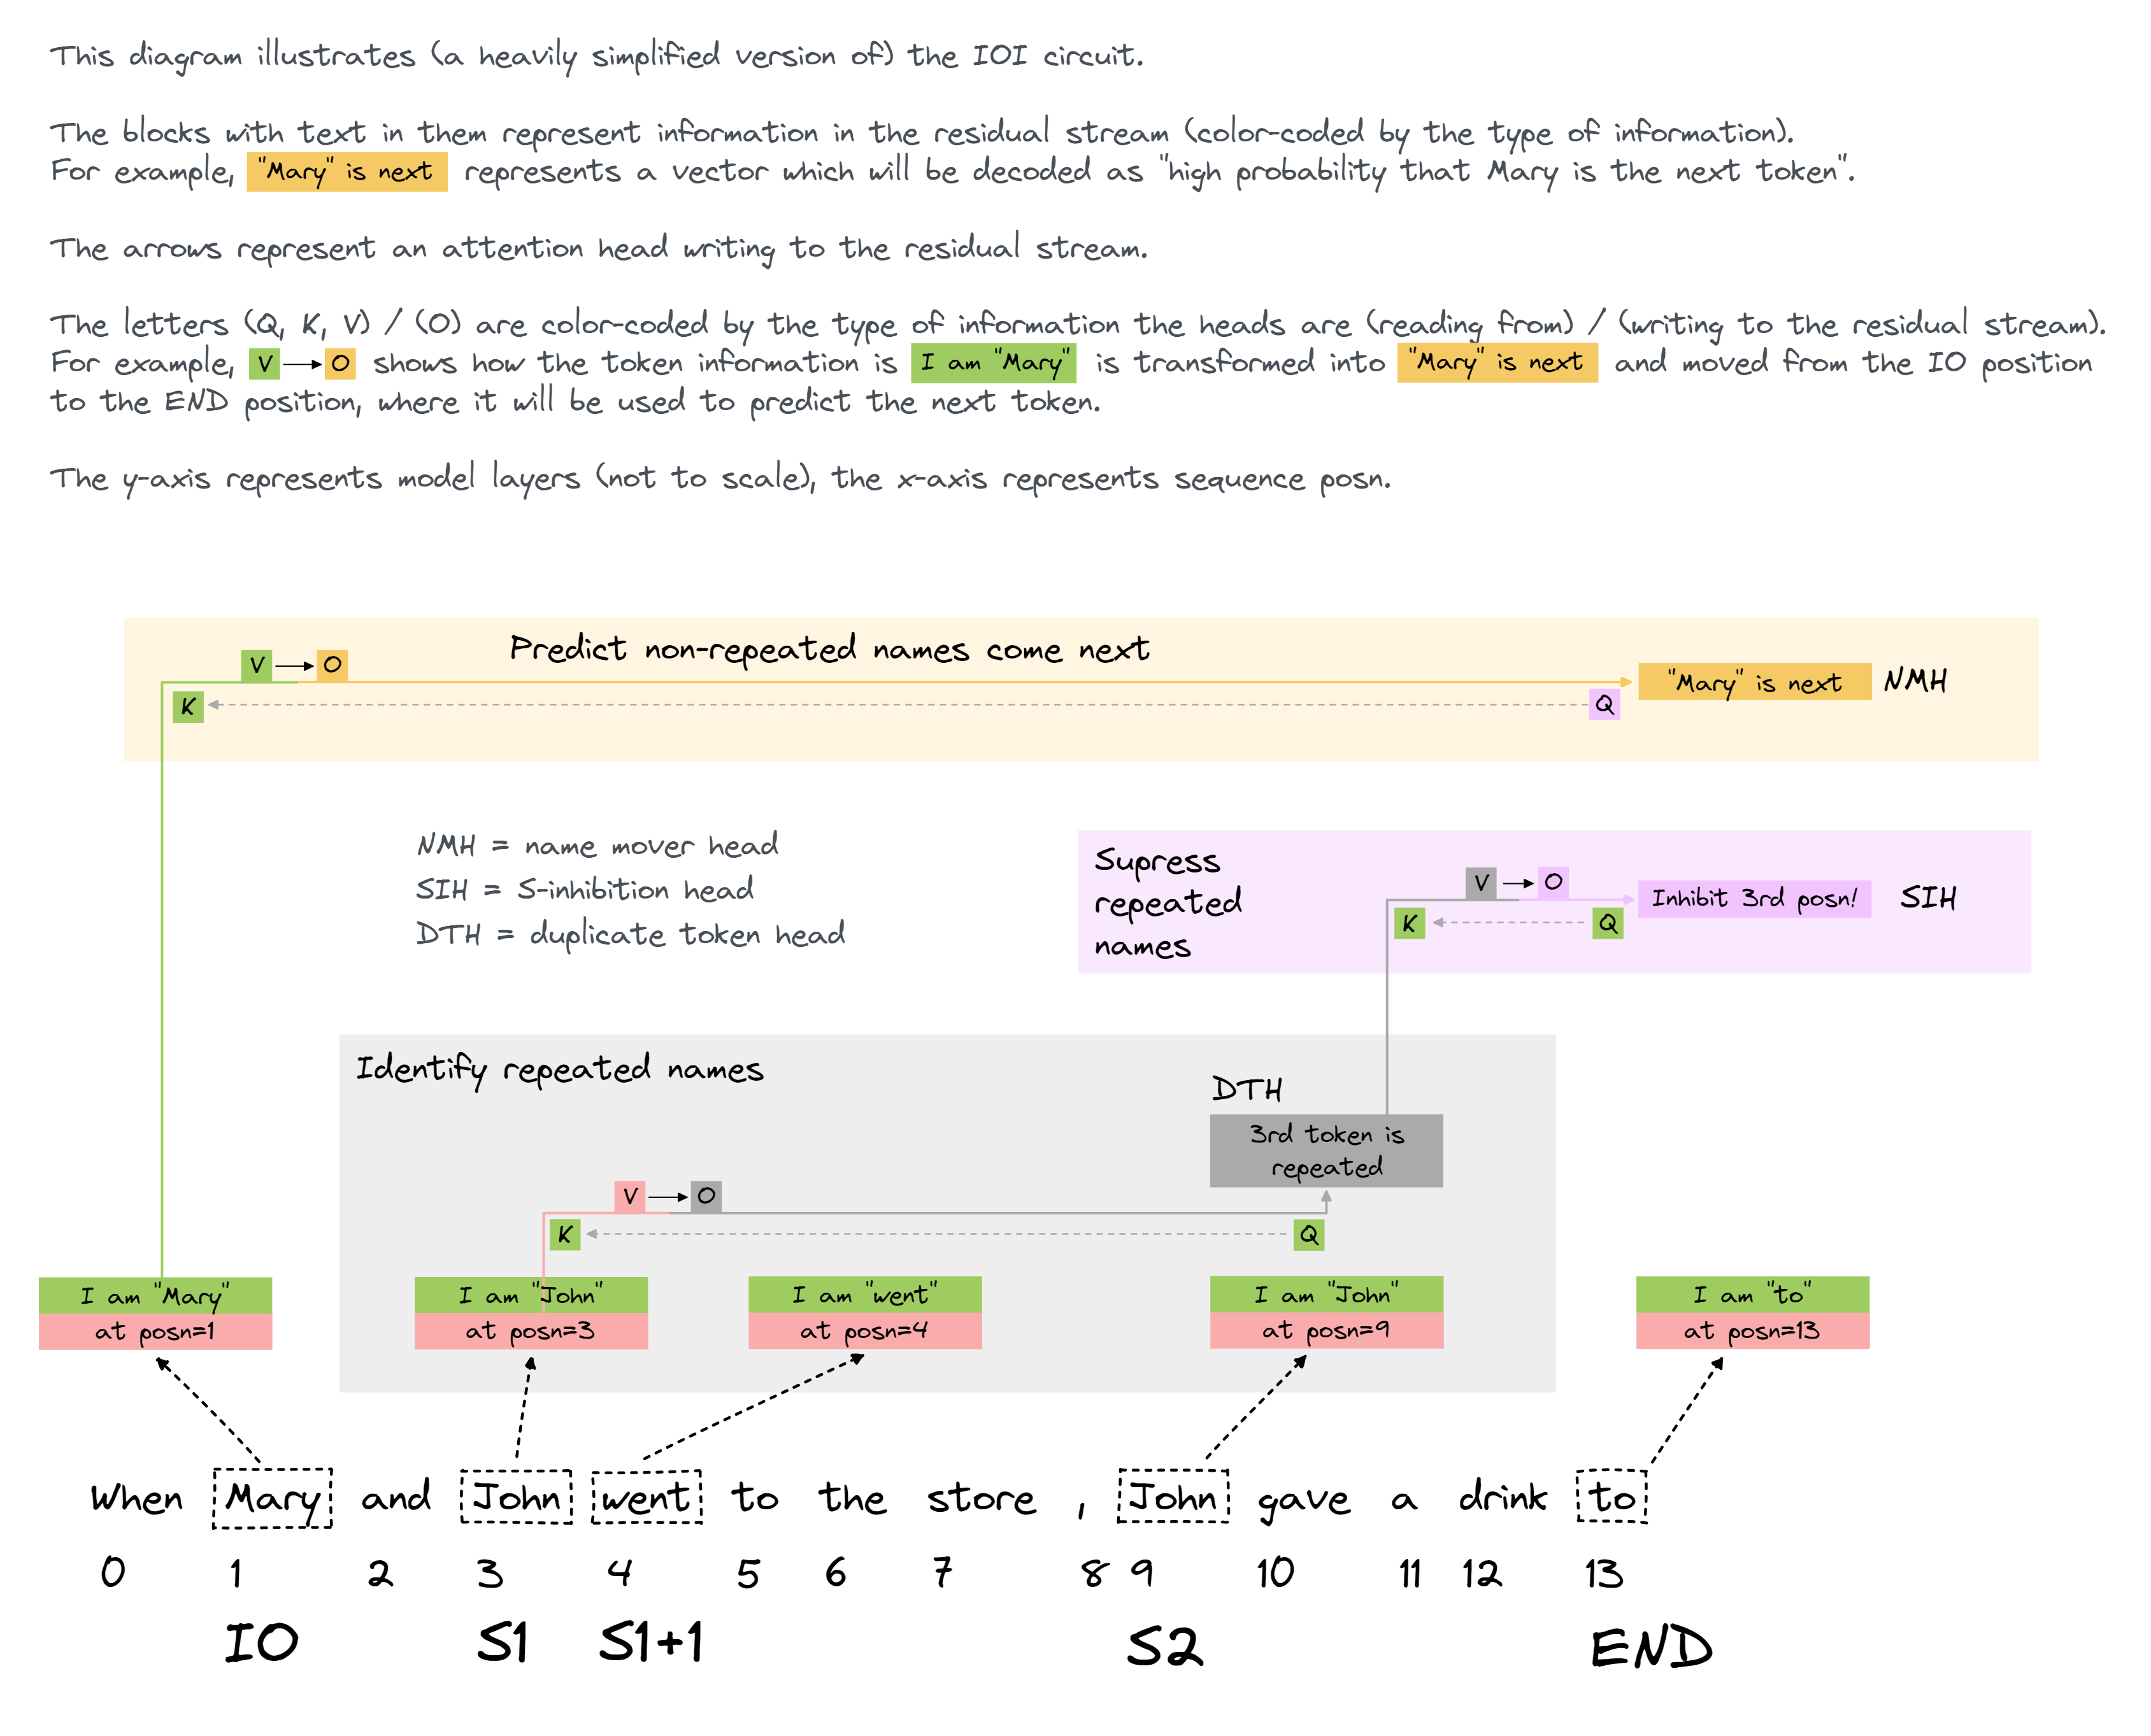

Explanation:

- We call the early heads **DTH** (duplicate token heads). Their job is to detect that S2 is a duplicate.

- The second group of heads are called **SIH** (S-inhibition heads). Their job is to move the duplicated token information from `S2` to `END`.
  - We've illustrated this as them moving the positional information, but in principle this could also be token embedding information (more on this in the final section).

- The last group of heads are called **NMH** (name mover heads). Their job is to copy the `IO` token to the `END` token, where it is used as the predicted next token.
  - Thanks to the S-inihbition heads, these heads don't pay attention to the `S` token.

## Comparison with paper results

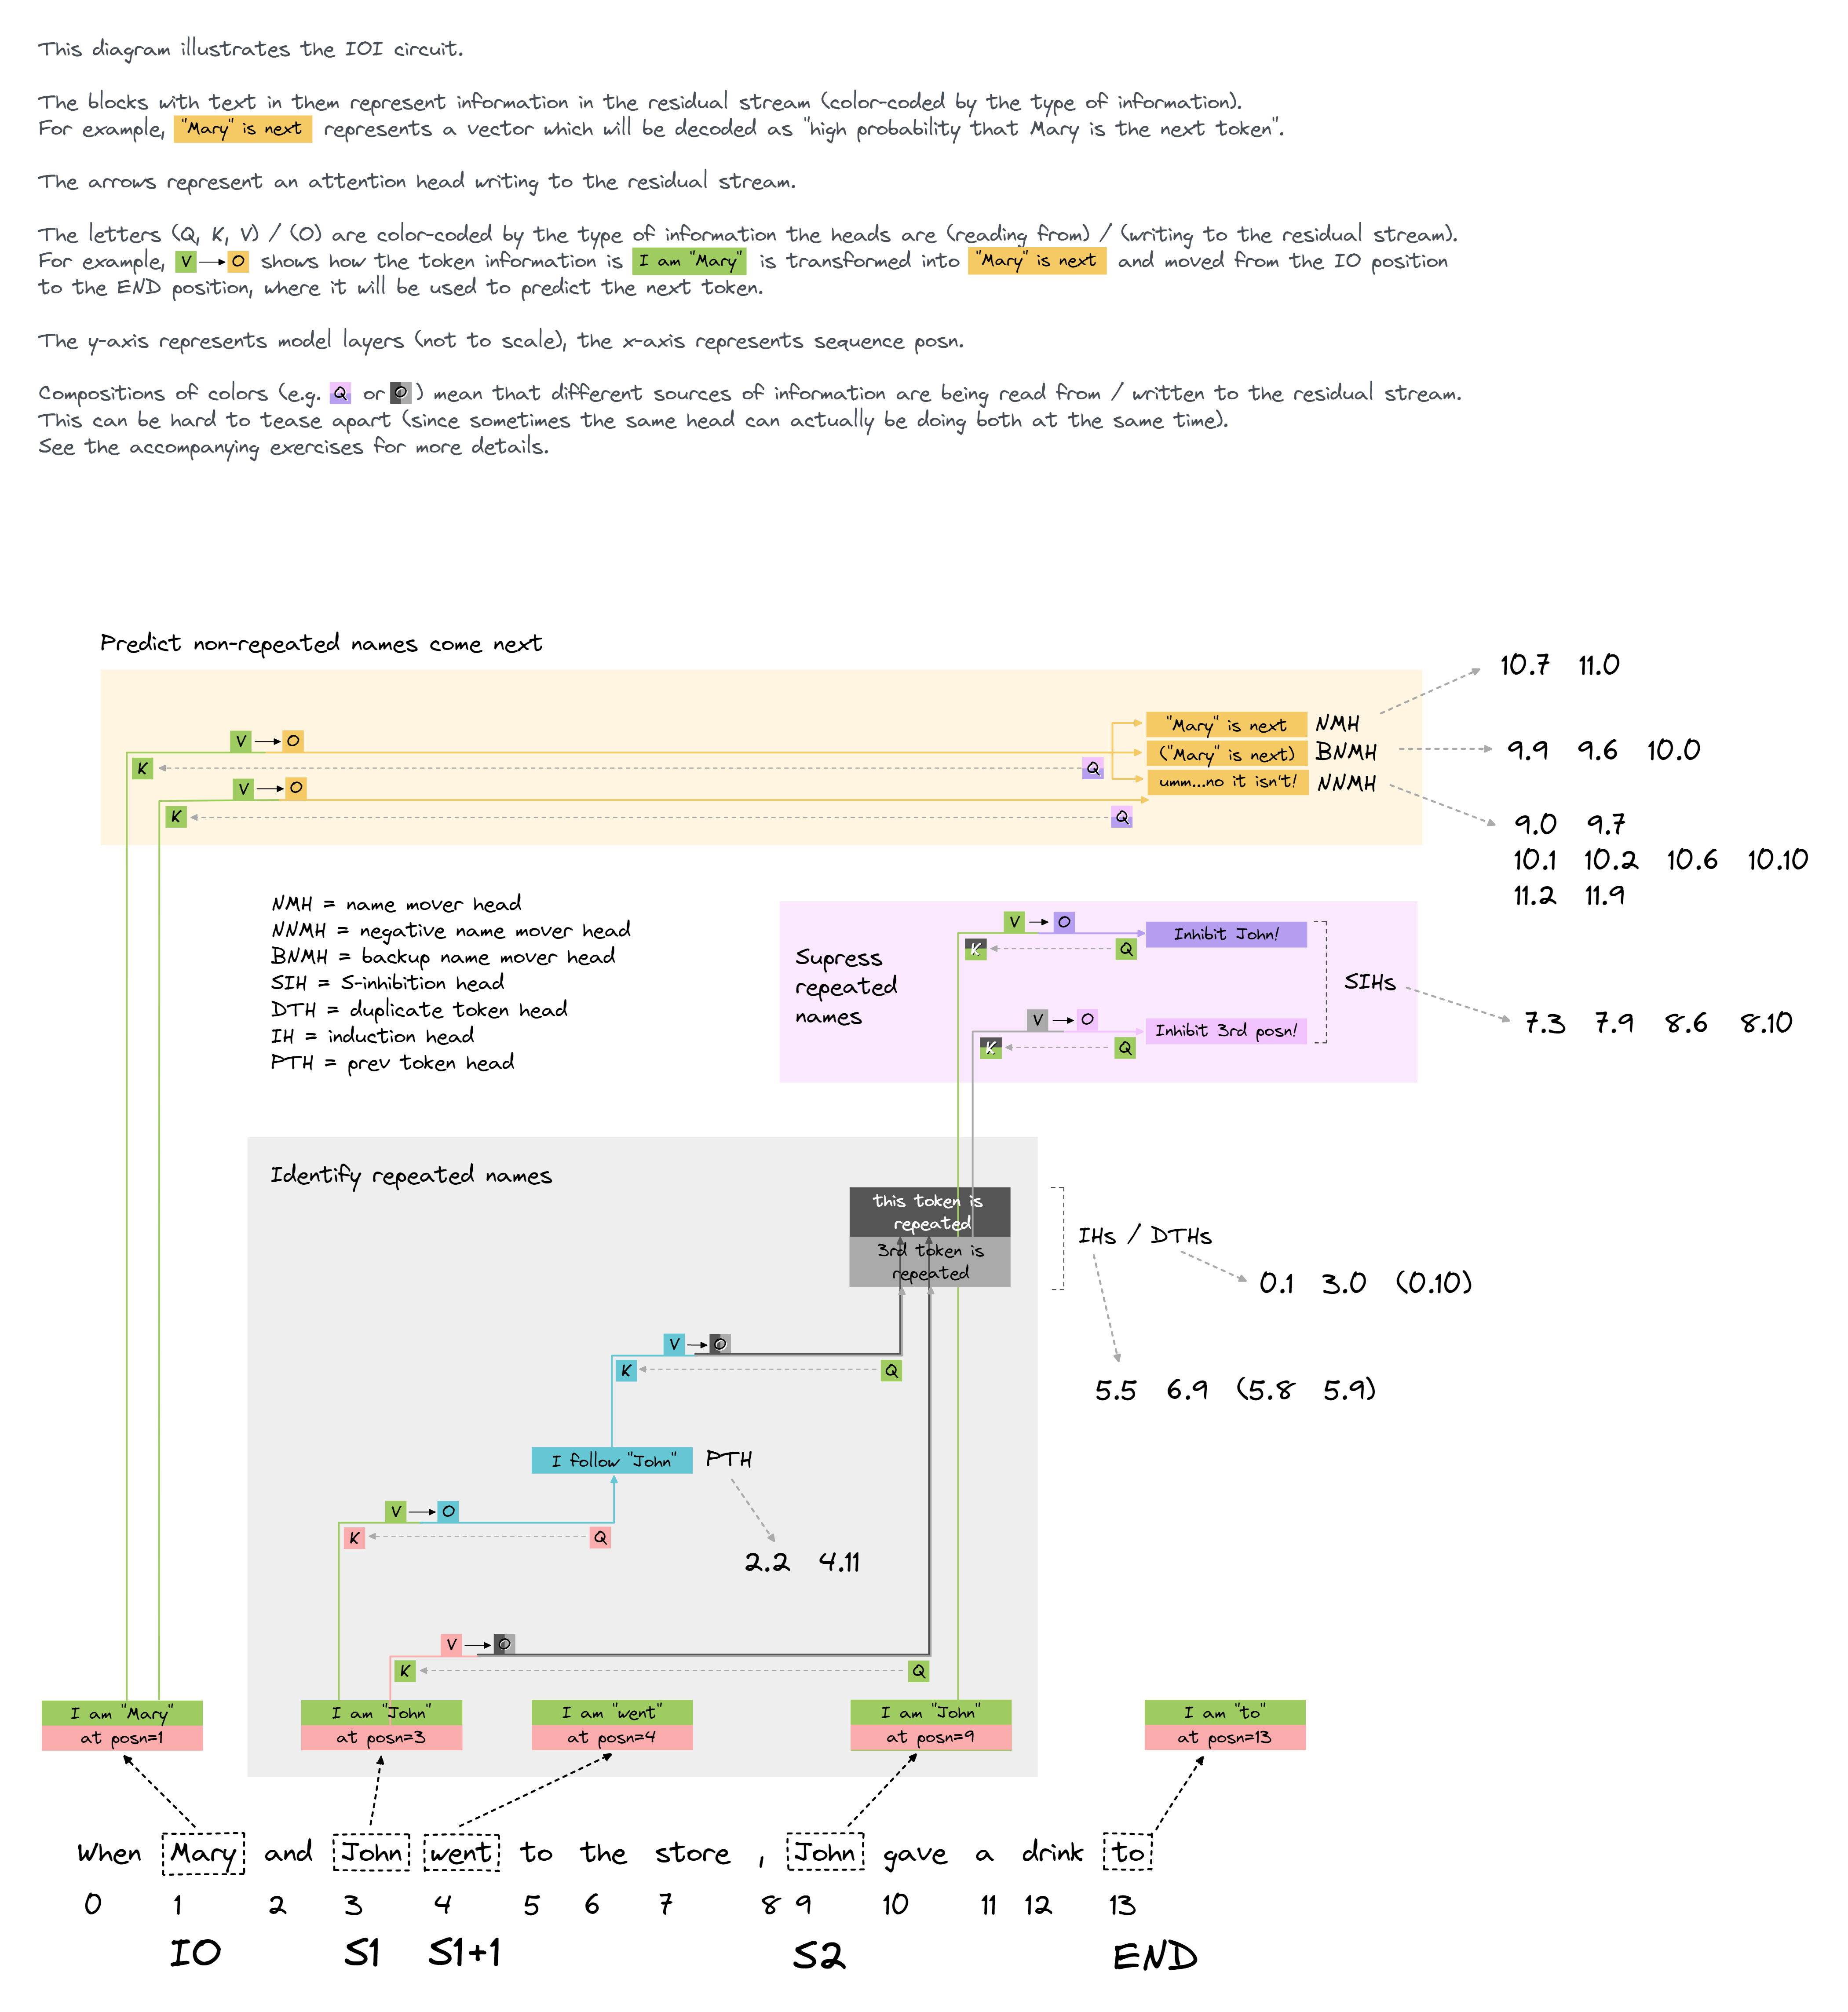

**Remember**: the boundaries of the circuit are fuzzy and the "role" of every head is in this circuit is a leaky abstraction. The diagram is primarily meant to point intuitions in the right direction for better understanding this circuit.

### Main differences from simplified diagram above:

#### Induction heads

- Rather than just having duplicate token heads in the first cluster of heads, we have two other types of heads as well: **previous token heads** and **induction heads**.

- The induction heads do the same thing as the duplicate token heads, via an induction mechanism. They cause token `S2` to attend to `S1+1` (mediated by the previous token heads), and their output is used as:

  1. a pointer to `S1`, and

  2. a signal that `S1` is duplicated

- **Note**: the induction heads and duplicate token heads do *not* compose with each other.

- Why inductions heads? Possibly because induction heads are a nearly default phenomenon that forms very early on in training.
  - It makes sense for the model to repurpose existing machinery.

#### Negative and Backup Name Mover heads 

- Remember that some heads were actually *harming* performance. These heads are similar to the Name Mover Heads, but in reverse: they inhibit the *correct* answer.
  - Not obvious why. The paper speculates that these serve as a hedge against  high cross-entropy loss when mistakes are made.

- When the Name Mover Heads are ablated, the Backup Name Mover Heads pick up the slack and do that task anyway. This is weird, especially because *they don not seem to perform this task when the NMHs are not ablated!*

  - This is an example of **built-in redundancy**

  - This possibly resulted from the model being trained with "dropout".  
    - Not fully satisfying, since models trained without dropout still seem to have BNMHs, just weaker.

#### Position vs token information

- 2 kinds of S-inhibition heads:
  - heads that inhibit based on position info, and
  
  - heads that inhibit based on token info

- Not clear which are doing which!
  - Some might even be doing both.
  - The paper has an ingenious way of teasing apart which type of information is being used by which of the S-inhibition heads. Will discuss later.

#### K-composition in the S-inhibition heads

- When we did activation patching on the keys and values of S-inhibition heads, we found that the *values were important* and the *keys were not*.
  - Conclusion: K-composition isn't really happening in these heads.
  - `END` must be paying attention to `S2` for reasons other than duplicate token info
    - E.g., it could be paying attention to the closest name, or to any names which aren't separated from it by a comma.

- Conclusion is *mostly* true, but there is *some* K-composition happening in these heads:
  - The duplicate token heads are writing the "duplicated" flag to the residual stream with no info about the identity or position of the token.
  - This flag is being used by the keys of the S-inhibition heads to make `END` pay attention to `S2`.

- Represented by dark grey boxes in diagram.

- Haven't seen any evidence of this so far, but will soon.

- **Note**: whether the early heads are writing position info or "duplicate flag" info to the residual stream is not necessarily related to whether the head is an induction head or a duplicate token head. In principle, either type of head could write either type of information.